In [0]:

from zipfile import ZipFile

file_name = "/content/drive/My Drive/Colab Notebooks/Road.zip"
with ZipFile(file_name,'r') as zp:
  # zip.printdir()
  zp.extractall()
  print('done')



done


In [0]:
import os

dirVal = '/content/validator'
dirValImage = dirVal+'/images'
dirValLabel = dirVal+'/mask'
os.mkdir(dirVal)
os.mkdir(dirValImage)
os.mkdir(dirValLabel)


In [0]:
from sklearn.model_selection import train_test_split
import glob


Str1 = "/content/data_segment/images/*.jpg"
Str2 = "/content/data_segment/mask/*.png"
train_path = glob.glob(Str1)
label_path = glob.glob(Str2)
train_path.sort()
label_path.sort()
x_train,x_val, y_train,y_val = train_test_split(train_path,label_path, test_size = 0.1,shuffle = True, random_state = 2)
# print(len(x_train))
for i in range(len(x_val)):
  val = x_val[i].split('/')[-1]
  v = y_val[i].split('/')[-1]
  os.rename('/content/data_segment/images/'+val, '/content/validator/images/'+ val)
  os.rename('/content/data_segment/mask/'+v, '/content/validator/mask/'+ v)
  print(val,v)

2399.jpg 2399.png
1583.jpg 1583.png
2695.jpg 2695.png
1733.jpg 1733.png
900.jpg 900.png
2629.jpg 2629.png
2559.jpg 2559.png
2580.jpg 2580.png
2471.jpg 2471.png
1140.jpg 1140.png
2480.jpg 2480.png
1237.jpg 1237.png
2253.jpg 2253.png
3002.jpg 3002.png
1864.jpg 1864.png
2277.jpg 2277.png
57.jpg 57.png
2067.jpg 2067.png
2974.jpg 2974.png
106.jpg 106.png
2754.jpg 2754.png
272.jpg 272.png
2703.jpg 2703.png
2494.jpg 2494.png
695.jpg 695.png
704.jpg 704.png
1958.jpg 1958.png
128.jpg 128.png
2043.jpg 2043.png
1135.jpg 1135.png
1152.jpg 1152.png
1574.jpg 1574.png
3001.jpg 3001.png
1628.jpg 1628.png
2294.jpg 2294.png
2587.jpg 2587.png
1602.jpg 1602.png
843.jpg 843.png
2666.jpg 2666.png
2158.jpg 2158.png
1974.jpg 1974.png
2337.jpg 2337.png
1985.jpg 1985.png
545.jpg 545.png
1426.jpg 1426.png
719.jpg 719.png
2110.jpg 2110.png
2304.jpg 2304.png
1592.jpg 1592.png
311.jpg 311.png
1095.jpg 1095.png
440.jpg 440.png
13.jpg 13.png
827.jpg 827.png
30.jpg 30.png
529.jpg 529.png
2785.jpg 2785.png
2576.jpg 257

In [0]:
from __future__ import print_function

from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import matplotlib
import matplotlib.pyplot as plt


# COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
#                           Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])


def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "rgb",
                    mask_color_mode = "grayscale",image_save_prefix  = "images",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = 'rgb',
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)

        yield (img,mask)


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
# data_gen_args = None
myGene = trainGenerator(2,'/content/data_segment','images','mask',data_gen_args,save_to_dir = None)
Val = trainGenerator(2,'/content/validator','images','mask',data_gen_args,save_to_dir = None)
# print(myGene.next)

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
input_size = (256,256,3)
inputss = tf.keras.layers.Input(input_size)
nfilter = 32
conv1 = tf.keras.layers.Conv2D(nfilter, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputss)
conv1 = tf.keras.layers.Conv2D(nfilter, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
node = {}
node["00"] = conv1
pre = 0
for i in range(5):
  if i !=0 :
    nfilter *= 2
    print(nfilter)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(node[str(i-1)+str(0)])
    conv2 = tf.keras.layers.Conv2D(nfilter, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(nfilter, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    drop1 =tf.keras.layers.Dropout(0.5)(conv2)
    node[str(i)+str(0)] = drop1
    # print("down "+str(i)+"0")
    up_fil = nfilter
    pre = 0
    for j in range(i):
        pre+=1
        up_fil = int(up_fil/2)
        up = tf.keras.layers.Conv2D(up_fil, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(node[str(i-j)+str(j)]))
        
        temp = [up]
        for k in range(pre):
          temp.append(node[str(i-j-1)+str(k)])
        mer = tf.keras.layers.concatenate(temp, axis = 3)
        # print(mer.shape)
        # drop2 = tf.keras.layers.Dropout(0.1)(mer)
        conv1 = tf.keras.layers.Conv2D(up_fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(mer)
        drop2 = tf.keras.layers.Dropout(0.5)(conv1)
        conv1 = tf.keras.layers.Conv2D(up_fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop2)
        drop2 = tf.keras.layers.Dropout(0.5)(conv1)
        node[str(i-j-1)+str(j+1)] = drop2


def loss_(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return tf.keras.losses.binary_crossentropy(
    y_true, y_pred) + dice_loss(y_true, y_pred)



node["04"] = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(node["04"])
# node["03"] = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(node["03"])
# out = [node["03"],node["04"]]
model = tf.keras.Model(inputss,outputs = [node["04"]])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# model.summary()
model.fit_generator(myGene,steps_per_epoch=2770//2,epochs=3,validation_data=Val,validation_steps=308//2)

64
128
256
512
Epoch 1/3
1385/1385 [==============================] - 134s 97ms/step - loss: 0.3338 - accuracy: 0.8601 - val_loss: 0.2418 - val_accuracy: 0.9234
Epoch 2/3
1385/1385 [==============================] - 133s 96ms/step - loss: 0.1851 - accuracy: 0.9395 - val_loss: 0.2050 - val_accuracy: 0.9285
Epoch 3/3
1385/1385 [==============================] - 133s 96ms/step - loss: 0.1543 - accuracy: 0.9487 - val_loss: 0.1419 - val_accuracy: 0.9512


done


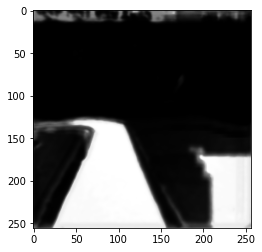

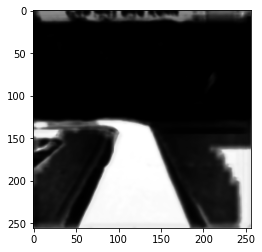

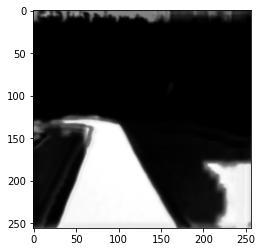

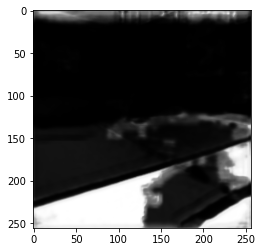

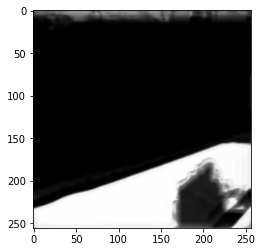

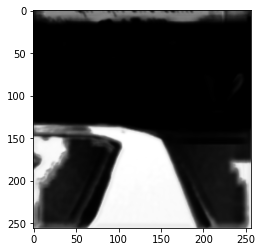

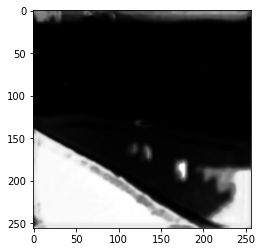

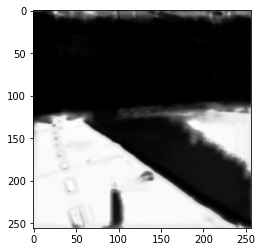

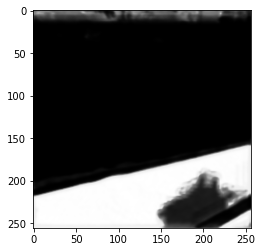

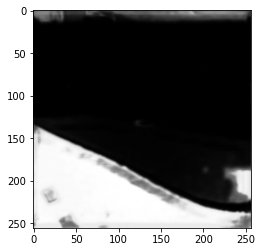

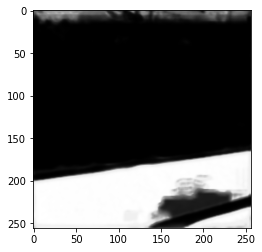

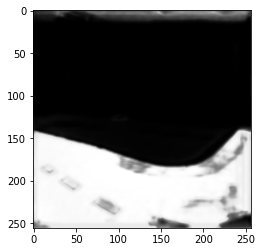

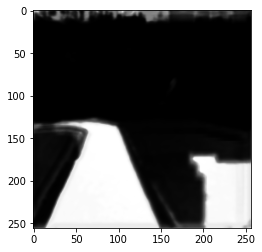

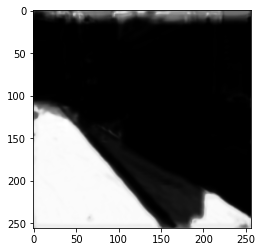

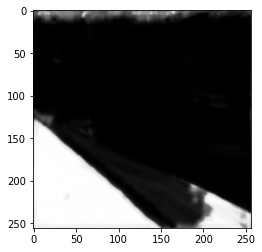

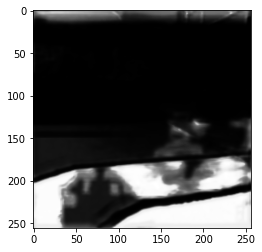

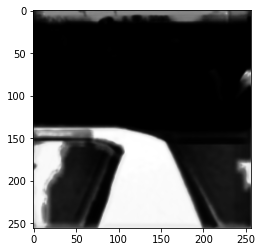

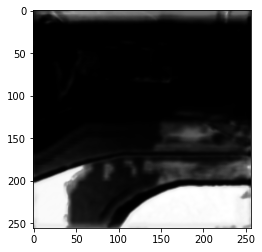

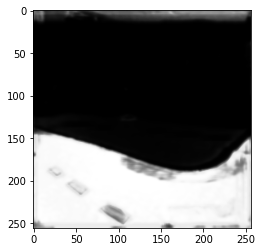

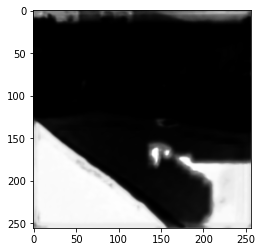

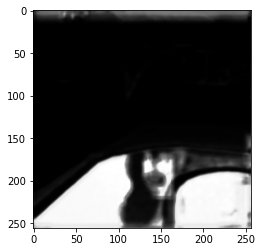

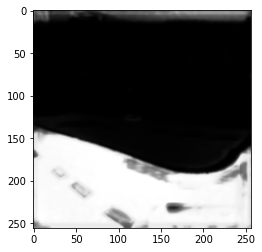

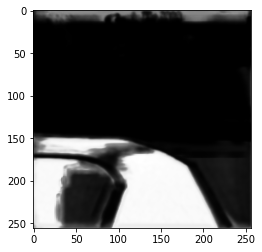

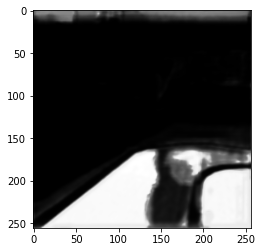

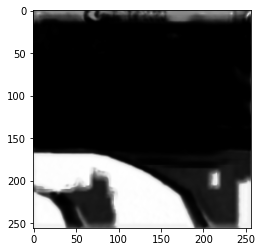

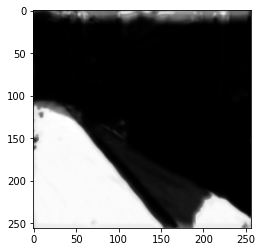

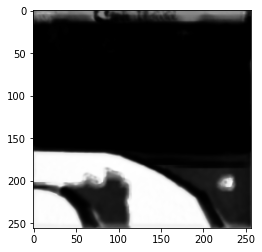

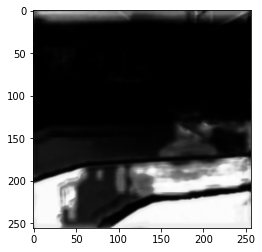

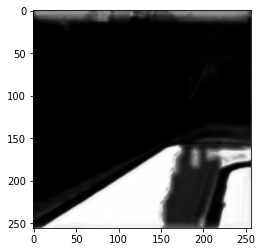

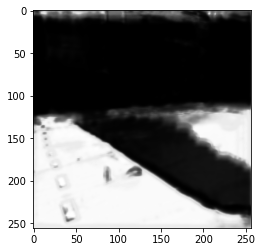

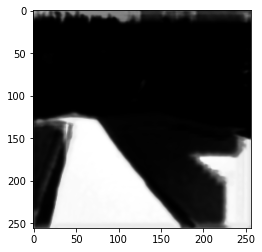

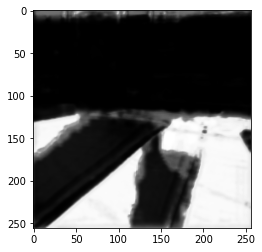

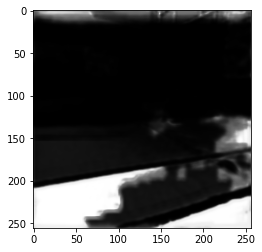

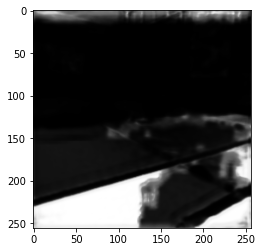

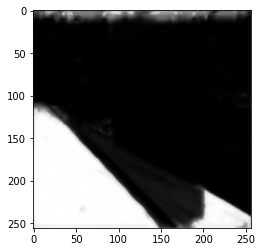

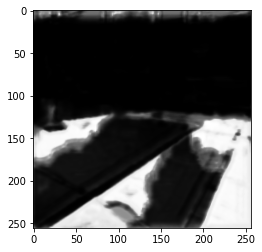

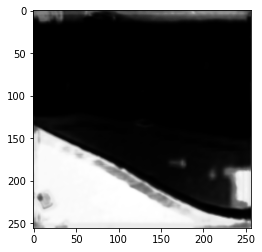

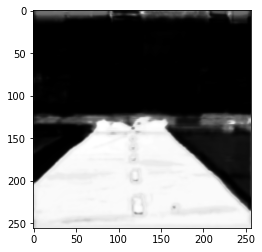

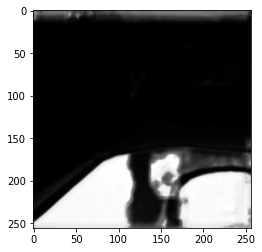

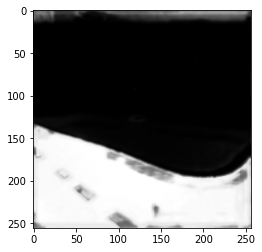

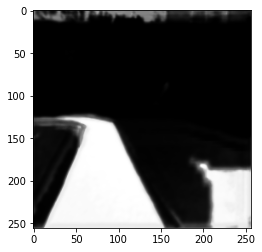

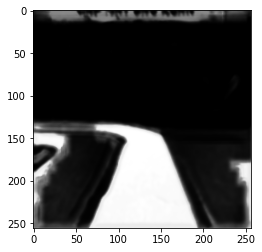

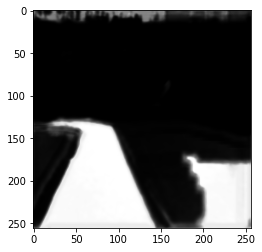

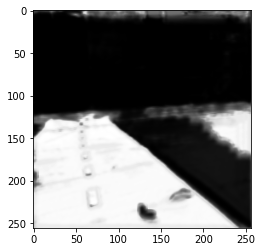

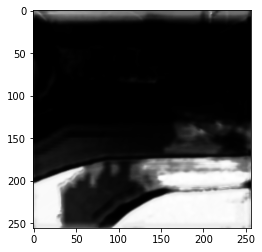

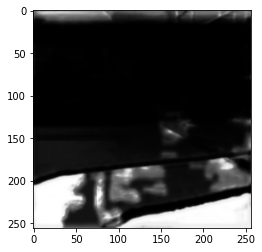

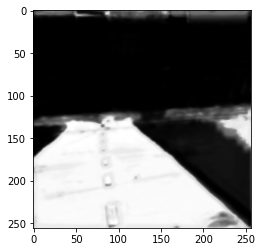

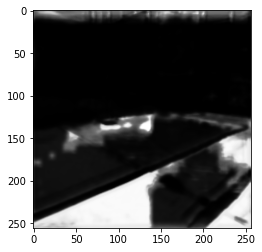

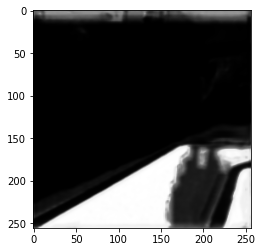

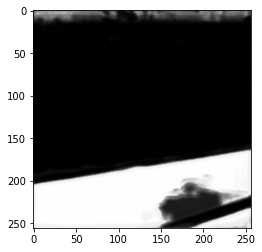

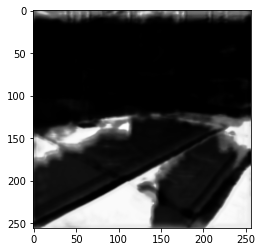

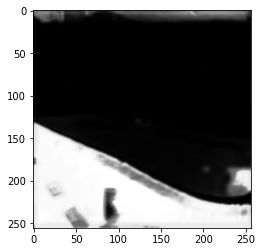

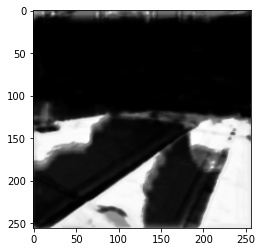

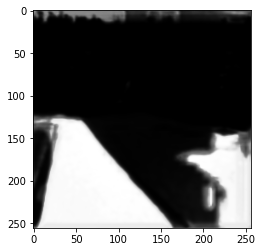

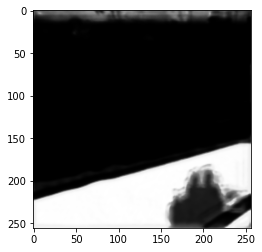

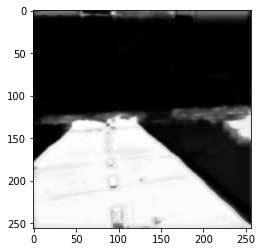

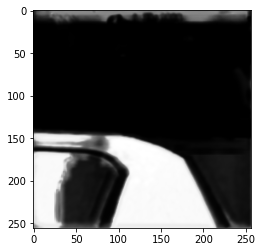

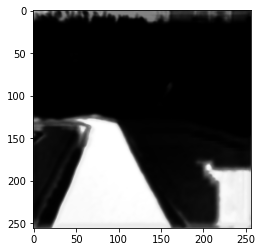

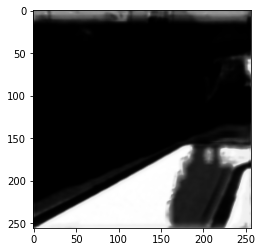

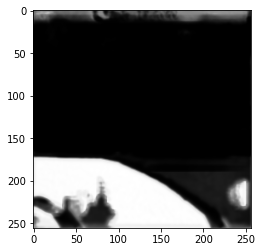

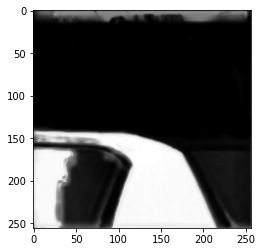

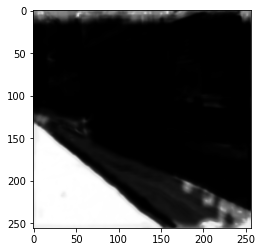

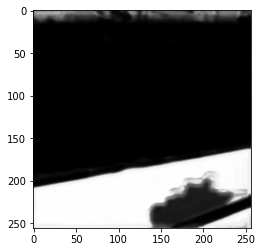

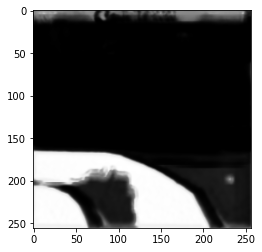

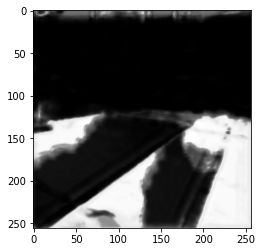

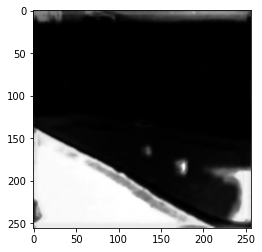

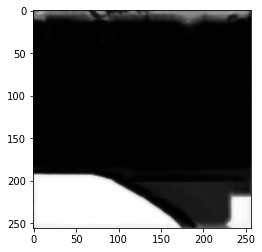

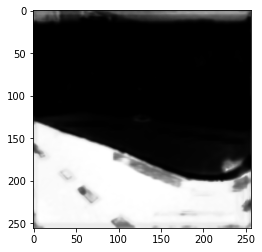

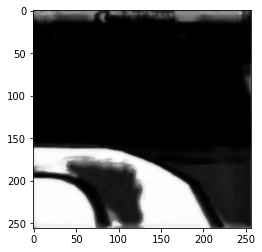

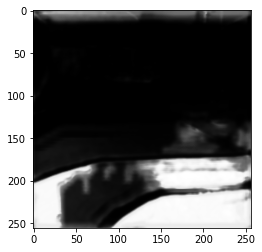

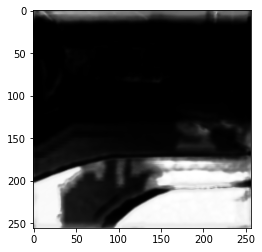

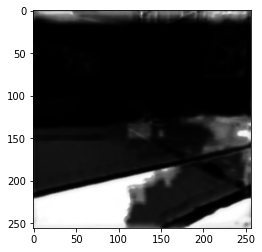

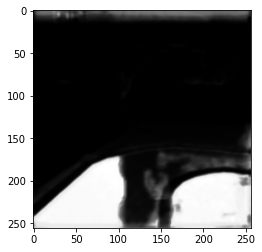

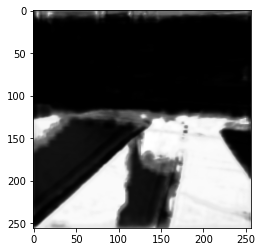

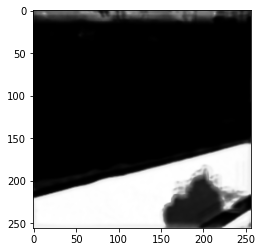

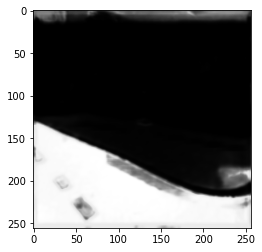

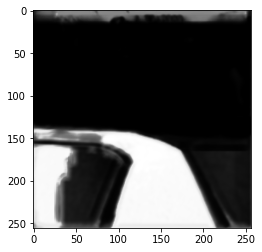

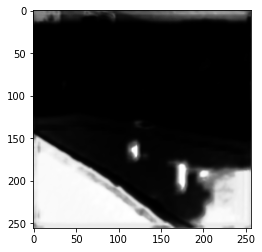

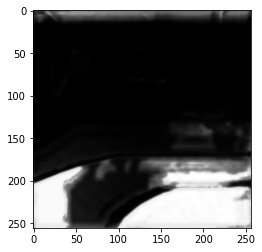

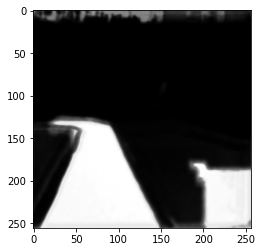

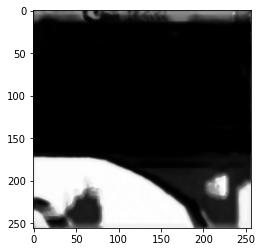

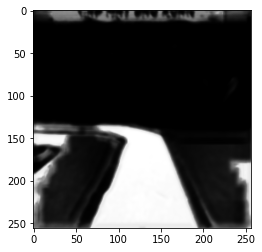

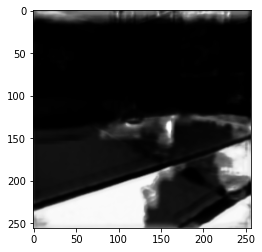

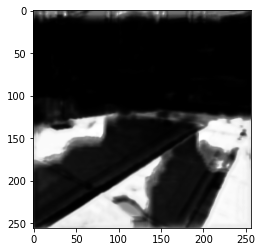

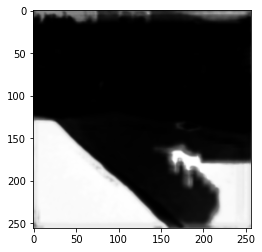

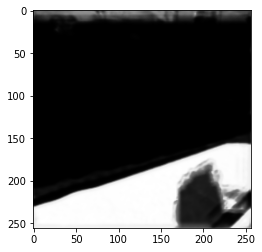

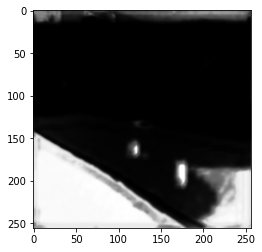

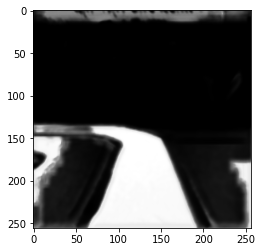

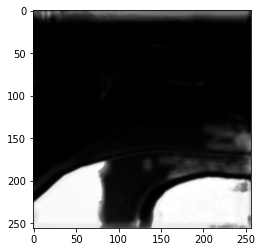

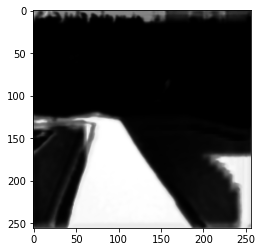

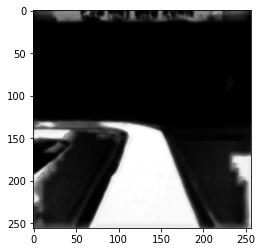

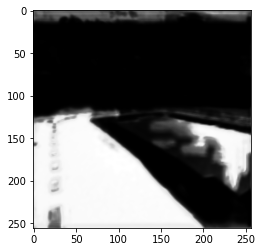

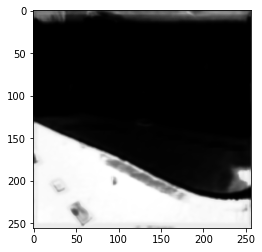

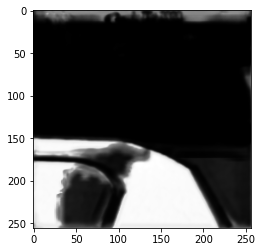

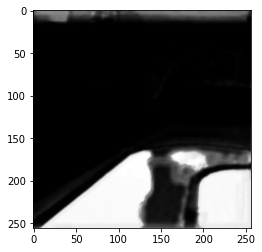

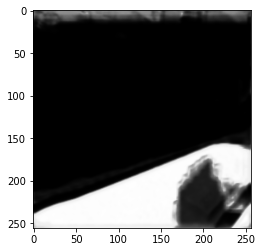

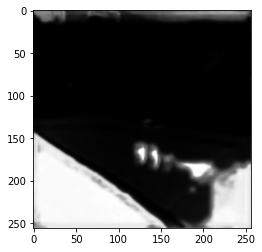

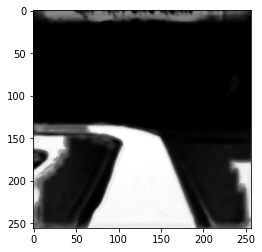

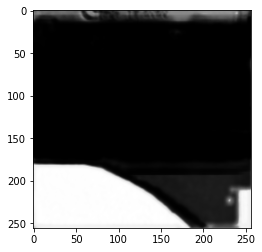

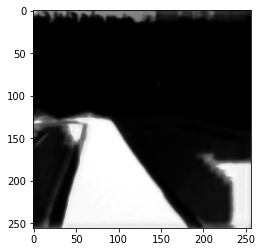

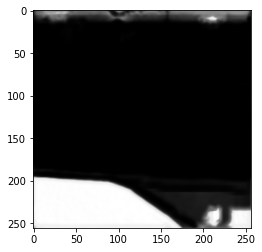

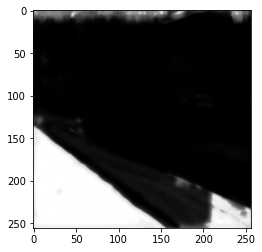

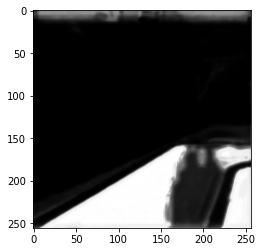

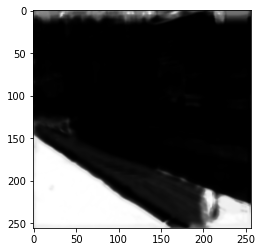

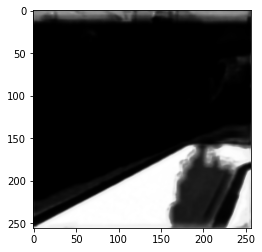

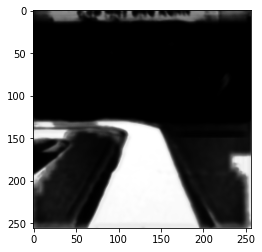

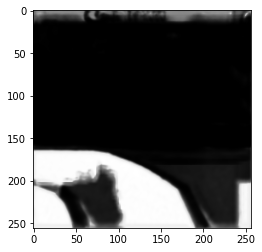

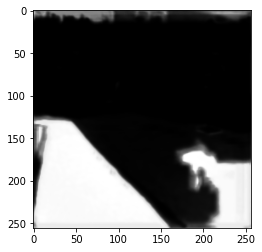

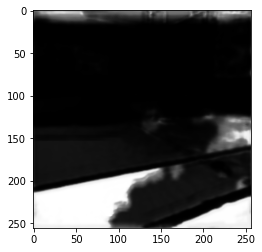

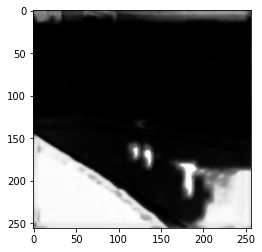

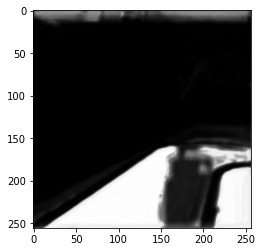

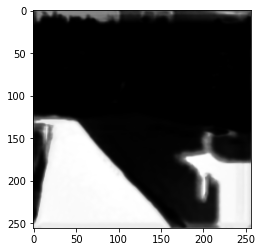

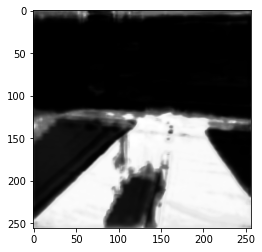

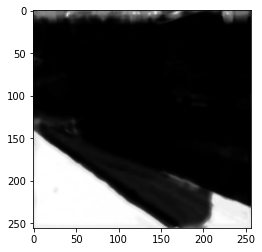

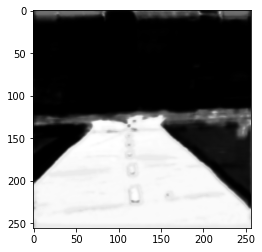

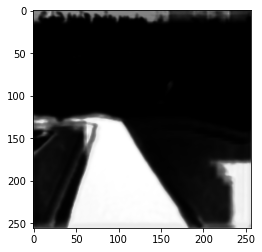

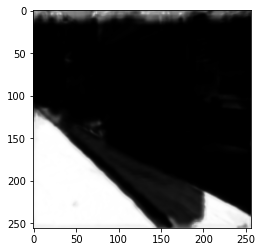

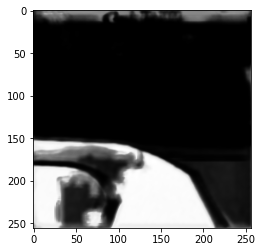

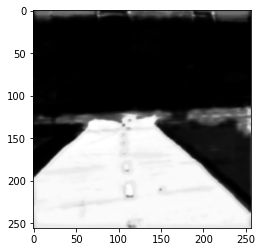

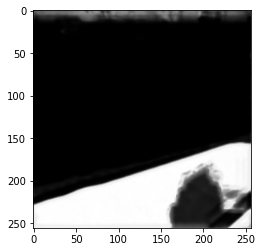

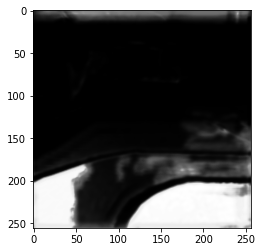

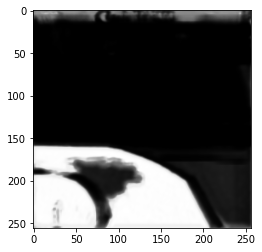

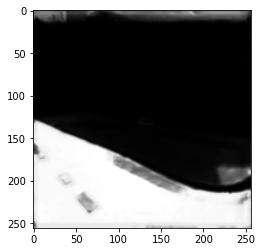

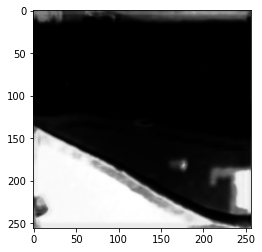

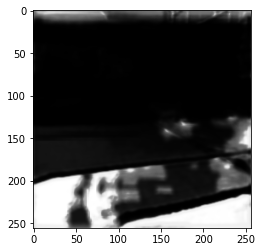

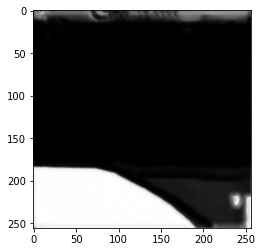

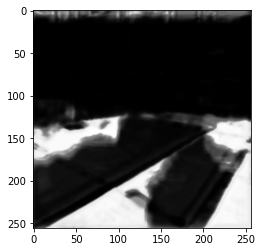

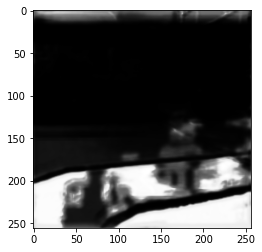

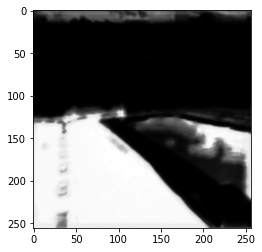

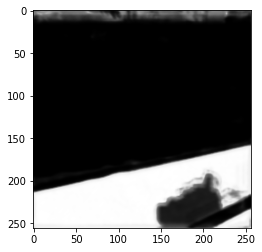

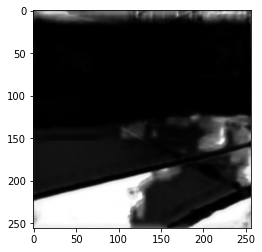

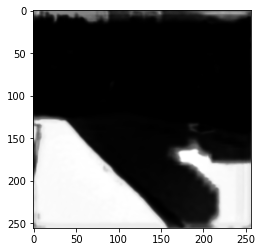

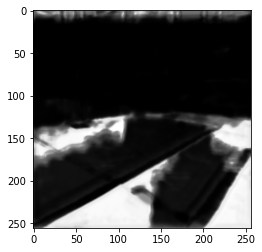

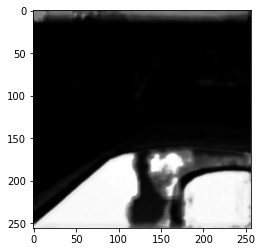

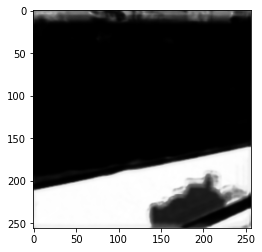

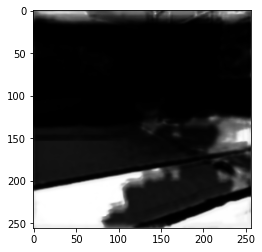

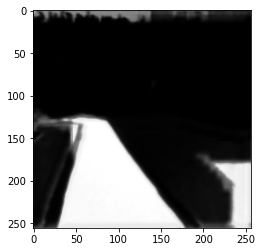

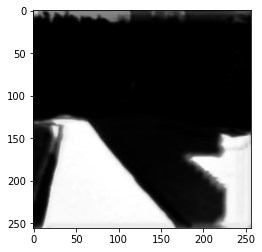

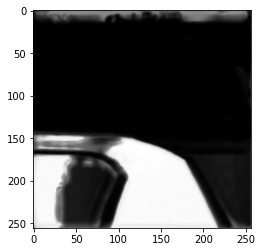

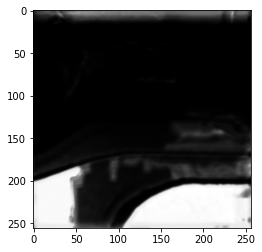

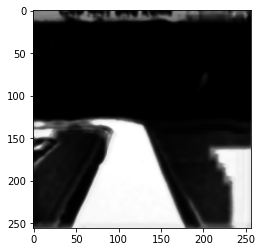

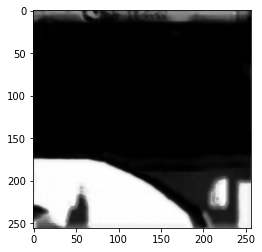

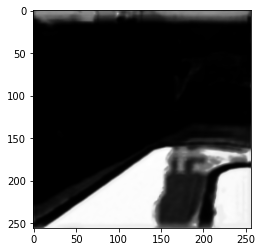

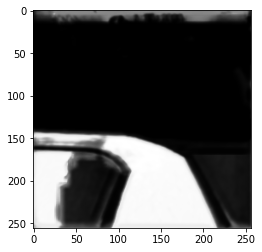

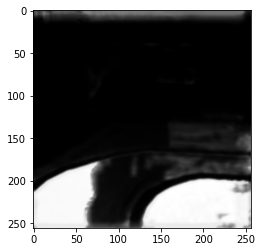

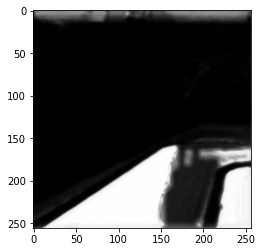

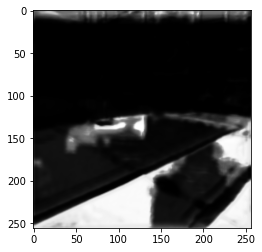

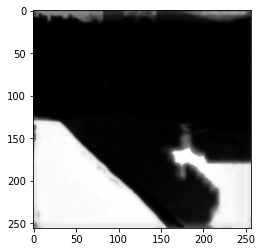

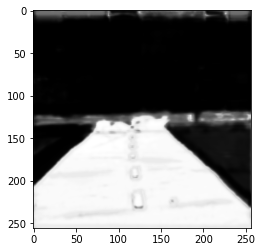

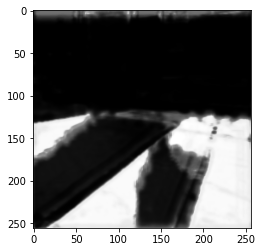

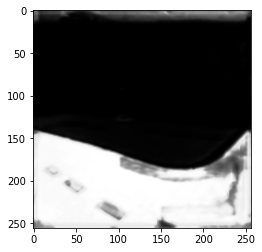

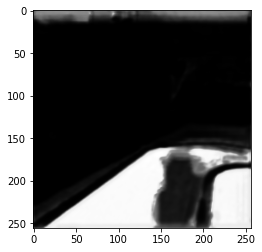

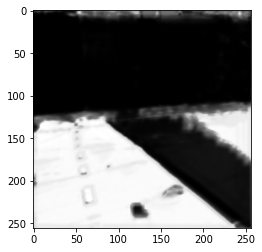

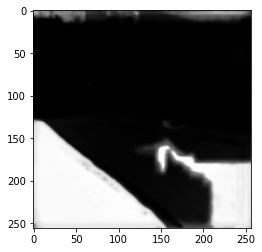

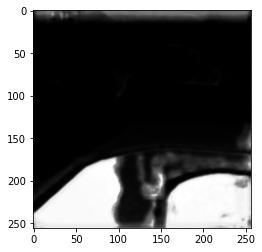

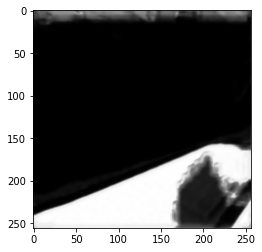

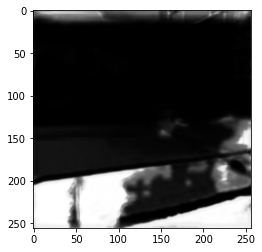

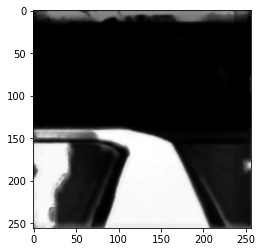

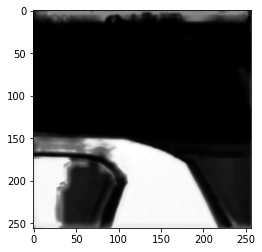

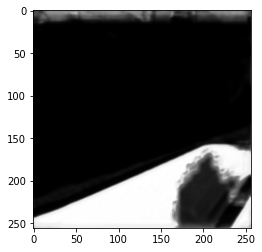

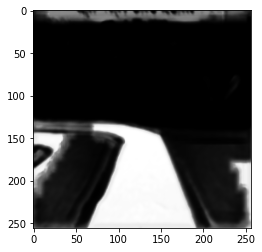

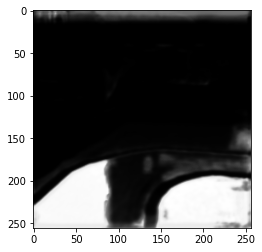

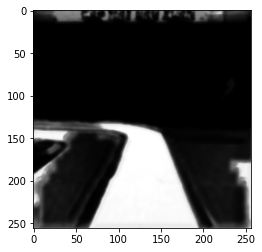

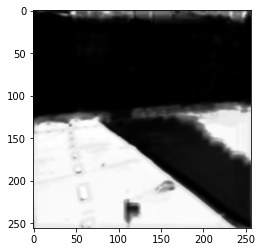

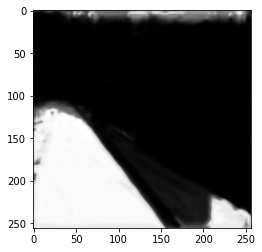

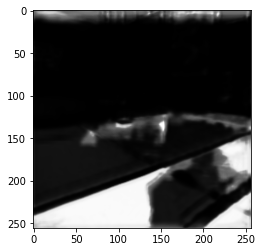

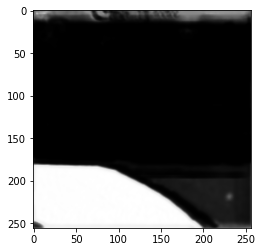

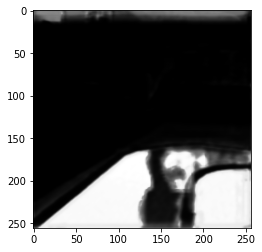

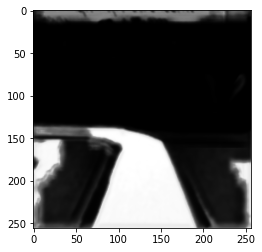

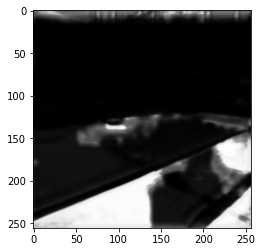

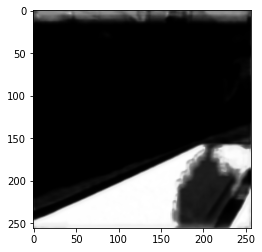

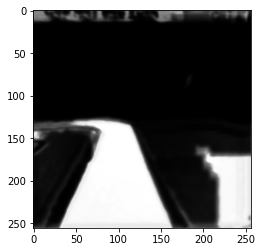

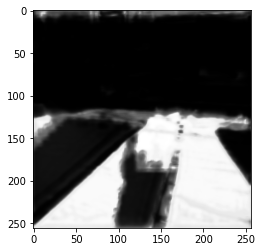

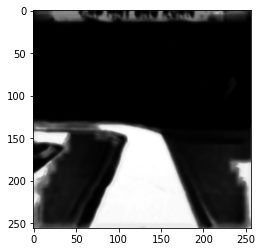

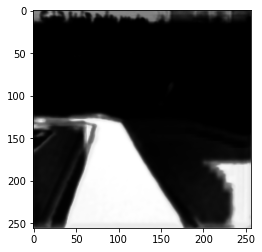

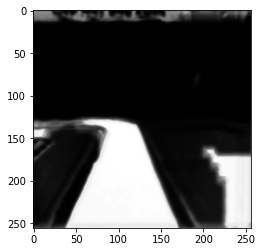

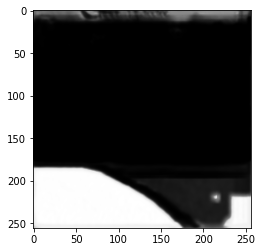

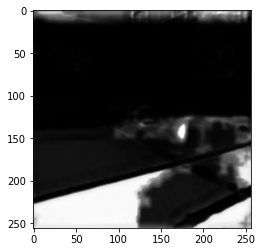

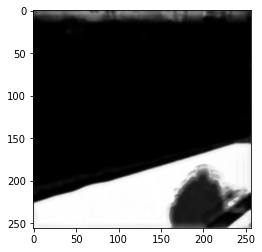

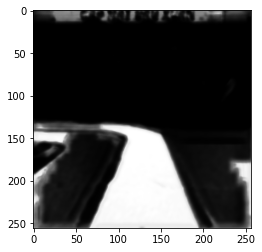

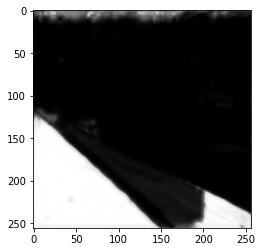

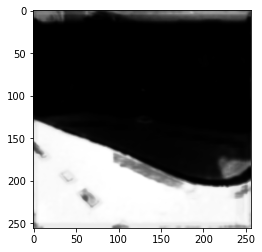

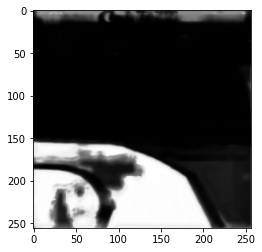

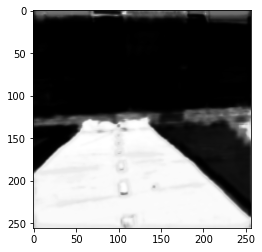

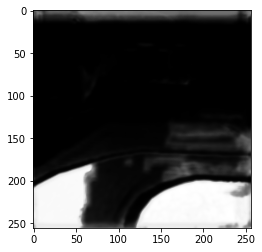

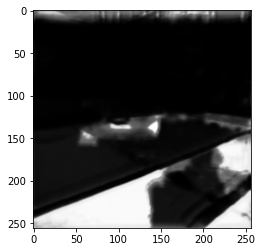

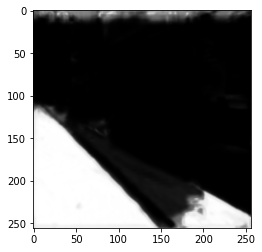

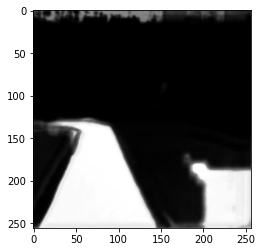

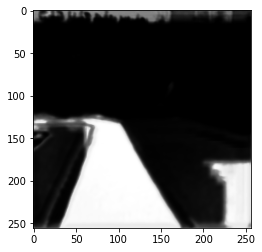

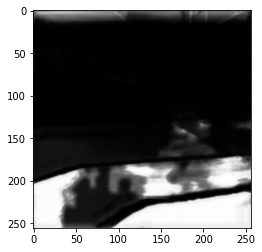

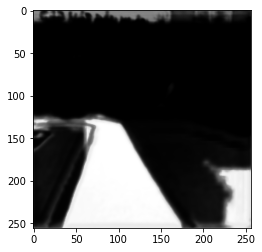

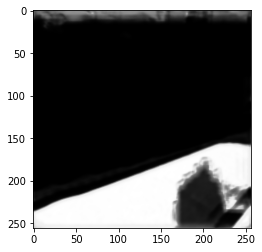

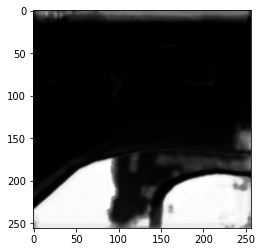

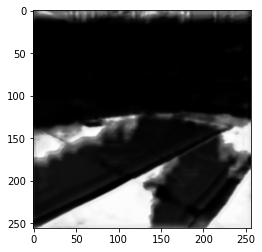

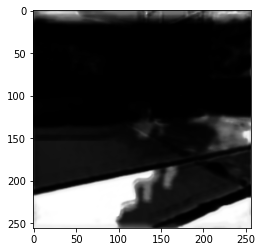

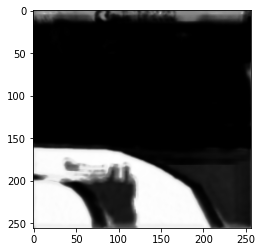

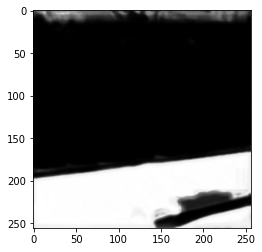

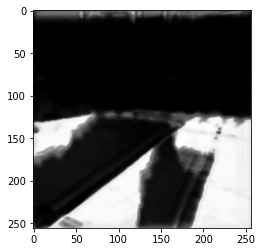

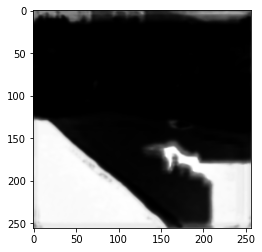

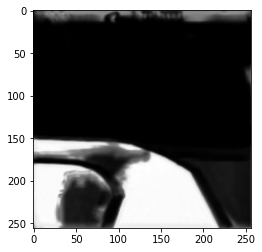

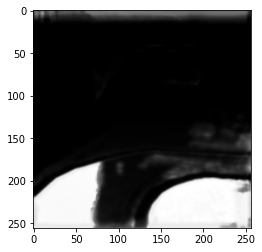

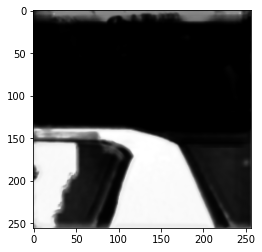

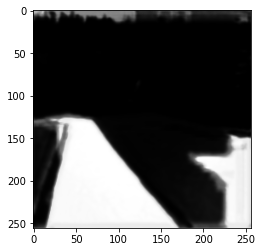

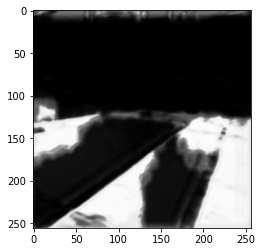

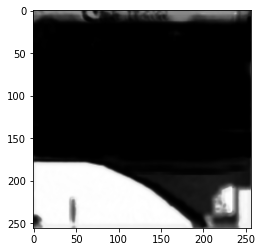

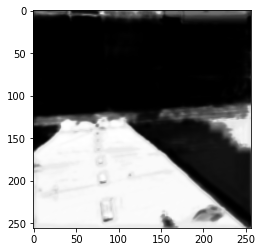

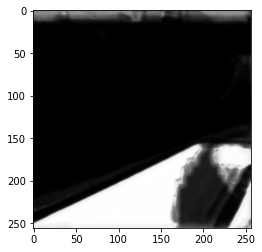

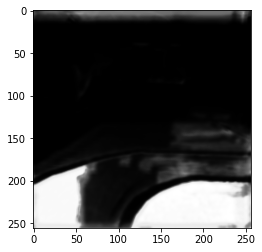

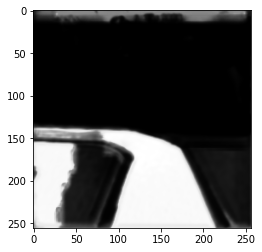

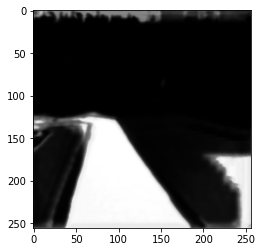

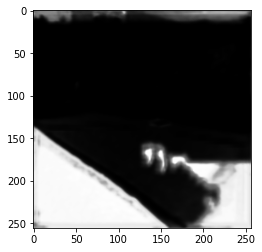

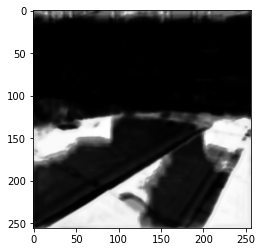

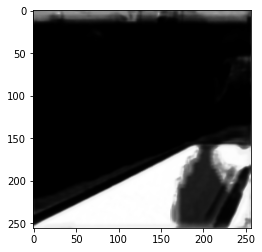

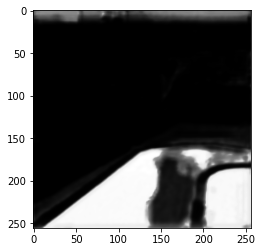

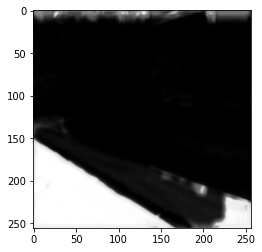

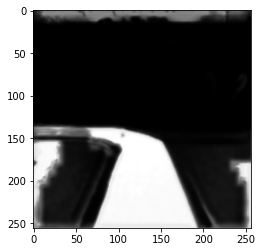

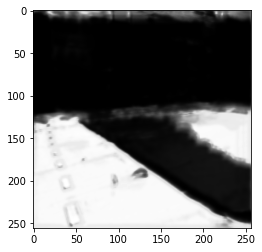

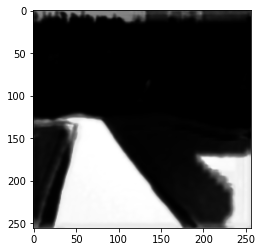

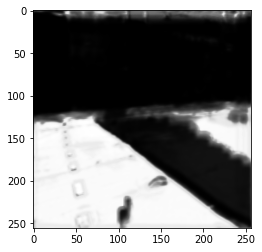

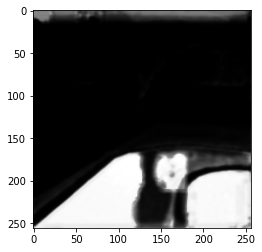

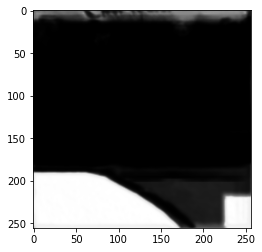

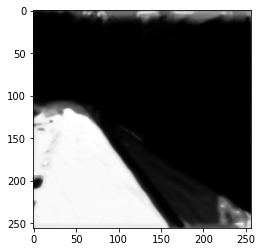

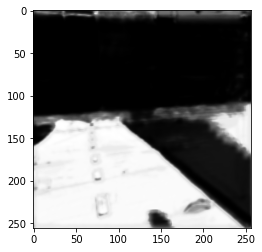

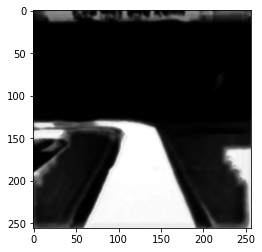

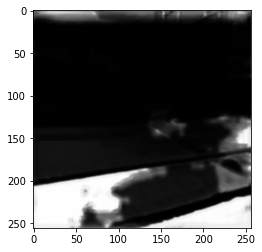

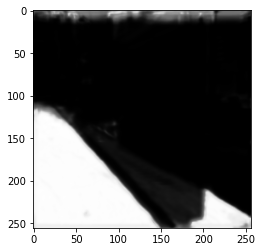

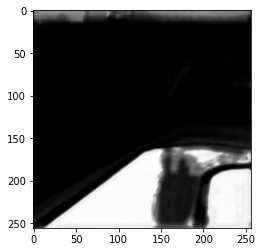

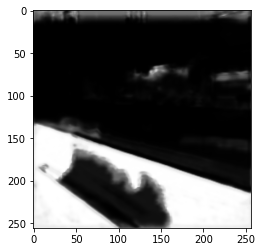

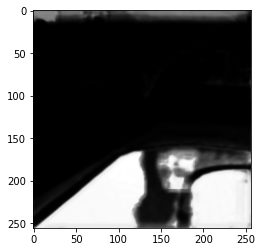

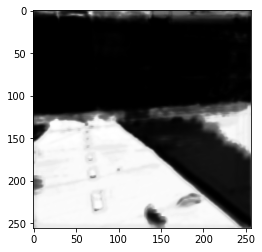

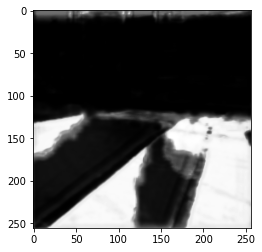

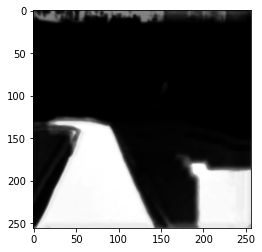

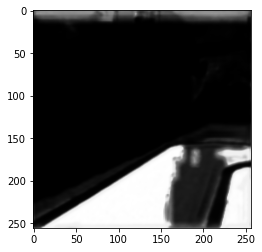

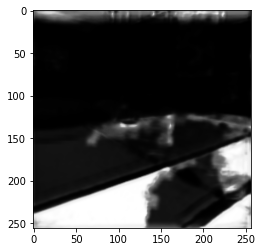

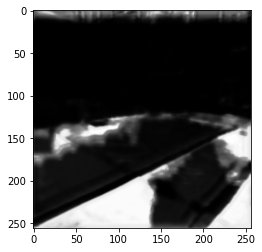

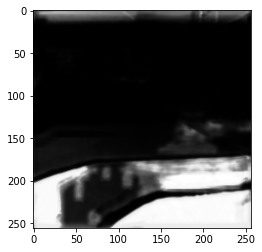

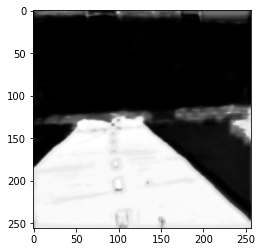

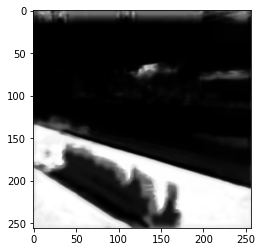

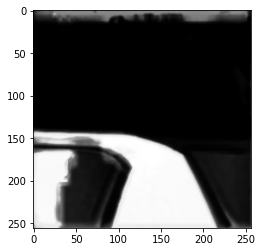

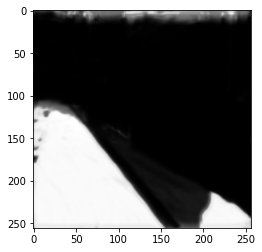

In [0]:
import cv2 as cv
from zipfile import ZipFile

file_name = "/content/drive/My Drive/Colab Notebooks/data_test.zip"
with ZipFile(file_name,'r') as z:
  # zip.printdir()
  z.extractall()
  print('done')

import glob

Str = '/content/data_test/*.jpg'
files = glob.glob(Str)

for f in files:

    img = cv.imread(f)
    img = cv.resize(img,(256,256))
    img = np.array(cv.cvtColor(img,cv.COLOR_BGR2RGB)).reshape(1,256,256,3)/255.0
    pred = model.predict(img)
    # i_ = im[0].reshape(480,640,3)
    img = img.reshape(256,256,3)
    # plt.imshow(img)
    # plt.show()

    p = np.array(pred).reshape(256,256)

    plt.imshow(p,cmap = 'gray')
    plt.show()

In [0]:

model.save_weights('my_model_weights.h5')


In [0]:
import cv2 as cv

import 